In [72]:
import pandas as pd
import numpy as np
from scipy import stats, interpolate
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from ipywidgets import interact

# get a list of all the colour strings in matplotlib so we can iterate through them
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colour_list = list(colors.keys())
# 9 base colours ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'aliceblue', 'antiquewhite', 'aqua'...

# Behind The Scenes Code

Read in Iteration Data (Training and NNet). Does all of the ugly calculations. Note, when the actions are changed, only self.action_space needs to be changed.

In [73]:
from IterationData import IterationData
# folder = os.path.join('..\Cartpole', 'Data\\')
# iter_data = IterationData(folder, iteration=0)
# iter_data.episode_data['Episode0'].tail()
# iter_data.all_data.tail()

Class To Visualise a Single Iteration. Generally these don't go quite as far as plotting, they create and return an axes object, which can then be plotted, or used in the Visualise class, which compares iterations

In [74]:
from VisualiseIteration import VisualiseIteration

In [75]:
folder = os.path.join('..\Cartpole', 'Data\\')
# iter_vis = VisualiseIteration(folder, 1)
# iter_vis.add_axis_valuevsstep(None, colour = 'blue', axes=None)
# iter_vis.add_axis_actionvsstep(None, agent='both', colour = 'blue', axes=None)
# iter_vis.get_episode_value_stats()
# iter_vis.plot_observations_histogram(normalised=True)

In [76]:
from VisualiseIterations import VisualiseIterations
help(VisualiseIterations)

Help on class VisualiseIterations in module VisualiseIterations:

class VisualiseIterations(builtins.object)
 |  VisualiseIterations principally contains a list of VisualiseIteration objects, which in turn contain Iteration data objects
 |  leading to an objects hirachy of VisualiseIterations <- Iter*VisualiseIteration <- IterationData. The main components of
 |  the two attribute classes are shown below:
 |  
 |  VisualiseIterations:
 |  Attributes:
 |      self.iters_data = [iter_data0, iter_data1, iter_data2, ...]
 |      self.iterations
 |  
 |  VisualiseIteration:
 |  Attributes:
 |      self.iter, self.action_space = [-1, 1], self.action_names ={0: 'Left', 1: 'Right'}
 |      self.default_action = 0  # left is default action to show (no need to show left and right)
 |      iter_data = IterationData(folder_path, iteration)
 |  Methods:
 |      add_axis_valuevsstep(self, episode=None, colour = 'blue', axes=None)
 |      add_axis_actionvsstep(self, episode=None, agent='player', colo

In [77]:
folder = os.path.join('..\Cartpole', 'Data\\')
v = VisualiseIterations(folder, [0, 1, 2])

There are  3  iterations stored in self.iterations


In [78]:
interact(v.vs_state_3d, angle=(0, 180, 5),
         iteration=(0 , v.iterations-1, 1),
         data_set=['PolicyAction', 'MCTSAction', 'PolicyAdv', 'MCTSAdv', 'PolicyValue', 'TrueValue'], 
         omitted_state=['x_dot', 'theta_dot'], 
         omitted_state_value=(-3, 3, 0.1), 
         binsize=(0.05, 2, 0.05))

interactive(children=(IntSlider(value=45, description='angle', max=180, step=5), IntSlider(value=0, descriptio…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

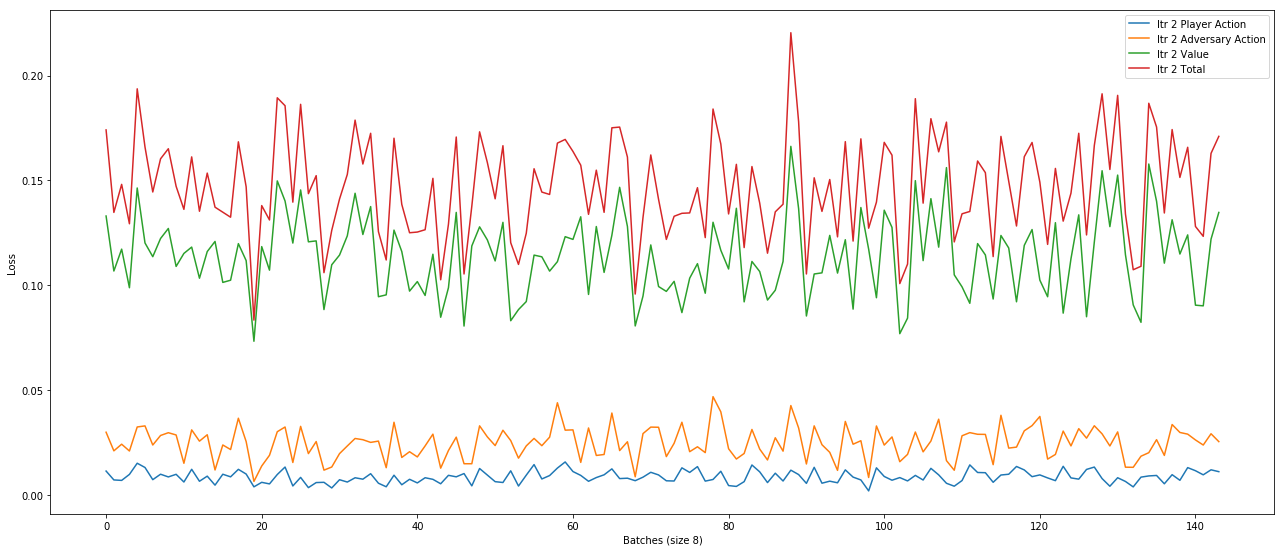

In [79]:
v.plot_nnet_lossesvsbatch(iters=[2])

In [84]:
v.plot_actionsvssteps()

AttributeError: 'VisualiseIteration' object has no attribute 'get_max_episode'

In [83]:
v.iters_data[0].iter_data.get_max_episode()

8